In [1]:
# import jax
# import equinox as eqx
# import optimistix as optx
# import jax.numpy as np
# import jax.util as jtu
# import jax.random as jr
# import jax.scipy as jsp
# import matplotlib.pyplot as plt
# import optax

# jax.config.update("jax_enable_x64", True)

In [2]:
import jax
import optax
import equinox as eqx
import optimistix as optx
import jax.numpy as np
import jax.random as jr
import jax.tree as jtu
import matplotlib.pyplot as plt
from jax import grad, vmap
from matplotlib import colormaps

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [3]:
from amigo.files import get_files


def load_cal(file_path, dithers=5):
    files = get_files(
        [f"{file_path}/CAL04481/calslope/"],
        "calslope",
        IS_PSF=[True],  # Calibrators
        EXPOSURE=[str(i + 1) for i in range(dithers)],
        FILTER=["F380M", "F430M", "F480M"],
    )
    for file in files:
        file["BADPIX"].data[:, -1:] = 1
        file["BADPIX"].data[41:43, 1] = 1
        file["BADPIX"].data[58, 67] = 1
    return files

In [4]:
from amigo.model_fits import PointFit
from amigo.misc import populate_from_state
from amigo.core_models import initialise_model
from amigo.ramp_models import build_pooled_layers, MinimalConv

# Load the state
idx = 48
path = "/Users/louis/PhD/Software/sandbox/amigo_notebooks/bunya/results/calibrate"
config = np.load(f"{path}/configs/config_{idx}.npy", allow_pickle=True).item()
calib_state = np.load(f"{path}/calib/final_states/state_{idx}.npy", allow_pickle=True).item()

# Build the model
files = load_cal("data/JWST", dithers=2)
model, exposures = initialise_model(files, PointFit(), Teff_cache="../data/Teffs")
ramp = MinimalConv(*build_pooled_layers(config["width"], config["depth"]))
model = populate_from_state(model.set("ramp", ramp), calib_state)

/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(
/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.

In [5]:
from amigo.ode_models import BaseNeuralODE, Polynomial, ODERamp
from amigo.misc import calc_laplacian
from amigo.stats import posterior

class MiniCNN(eqx.Module):
    layers: list

    def __init__(self, in_channels, width, out_channels, seed):
        keys = jr.split(jax.random.PRNGKey(seed), 2)
        self.layers = [
            eqx.nn.Conv2d(
                in_channels=in_channels,
                out_channels=width,
                kernel_size=3,
                padding=(1, 1),
                key=keys[0],
                use_bias=False,
            ),
            eqx.nn.Conv2d(
                in_channels=width,
                out_channels=out_channels,
                kernel_size=3,
                padding=(1, 1),
                key=keys[1],
                use_bias=False,
            ),
        ]

    def __call__(self, x):
        if x.ndim == 2:
            x = x[None, ...]
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        out = np.squeeze(self.layers[-1](x))
        return out

    @property
    def size(self):
        return np.sum(np.array(jtu.leaves(jtu.map(lambda x: x.size, self.layers))))


class NeuralODE(BaseNeuralODE):

    def __init__(self, width=16):
        self.network = MiniCNN(2, width, 1, 0)

    def eval_network(self, t, charge, illuminance):
        x = np.array([t * illuminance, calc_laplacian(charge)])
        return self.network(x)


class PolynomialNeuralODE(NeuralODE):
    poly_fn: Polynomial

    def __init__(self, start=1, order=5, width=16):
        self.poly_fn = Polynomial(start, order)
        self.network = MiniCNN(2, width, self.poly_fn.n, 0)

    def __getattr__(self, name):
        if hasattr(self.poly_fn, name):
            return getattr(self.poly_fn, name)
        super().__getattr__(name)

    def eval_poly(self, t, coeffs):
        return eqx.at(lambda x: x.coeffs, self.poly_fn, coeffs).evaluate(t)

    def qt(self, t, charge, illuminance):
        coeffs_vec = self.eval_network(t, charge, illuminance).reshape(self.n, -1)
        eval_fn = vmap(self.eval_poly, (None, 0))
        return eval_fn(t, coeffs_vec.T).reshape(charge.shape)

    def dqdt(self, t, charge, illuminance):
        coeffs_vec = self.eval_network(t, charge, illuminance).reshape(self.n, -1)
        grad_fn = vmap(grad(self.eval_poly), (None, 0))
        return grad_fn(t, coeffs_vec.T).reshape(charge.shape)

    def derivative(self, t, charge, illuminance):
        # Linear response to incoming photons
        dqdt = illuminance

        # Nonlinear pixel value, predicted via a CNN
        # dqdt += self.dqdt(t, charge, illuminance)
        dqdt += self.qt(t, charge, illuminance)
        return dqdt


# Various things to try here:
# - Use qt rather than dqdt
# - Feed in illuminance * t, charge
# - Polynomial as function of t * illuminance, rather than just t
# - Different network architectures
# - Dont predict polynomial coefficients, predict dqdt directly

In [6]:
@eqx.filter_jit
# @eqx.debug.assert_max_traces(max_traces=1)
def min_fn(ode_model, args):
    model, exposures = args
    model = model.set("ramp", ode_model)
    return np.array([-posterior(model, exp).mean() for exp in exposures]).mean()

# Define the ODE model
ODE = NeuralODE(width=64)
ode_model = jtu.map(lambda x: 1e-1 * x, ODERamp(ODE, oversample=1))
print(f"N ODE parameters: {ODE.network.size}")

# Compile the function
args = (model, exposures)
loss = min_fn(ode_model, args)
print(loss)

N ODE parameters: 1728
75.19834401779181


In [7]:
%%timeit
_ = min_fn(ode_model, args).block_until_ready()

4.88 s ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%time
optim = optax.adam(2e-3)
print_vals = frozenset({"step", "loss"})
solver = optx.BestSoFarMinimiser(
    optx.OptaxMinimiser(optim=optim, rtol=1e-6, atol=1e-6, verbose=print_vals)
)
sol = optx.minimise(min_fn, solver, ode_model, args=args, max_steps=2500, throw=False)
trained_ode = sol.value

Step: 0, Loss: 75.19834401779178
Step: 1, Loss: 61.20122683050261
Step: 2, Loss: 54.61600029053179
Step: 3, Loss: 55.874177667421904
Step: 4, Loss: 54.923734442011394
Step: 5, Loss: 51.2513706417882
Step: 6, Loss: 48.41705497715964
Step: 7, Loss: 47.651718376009036
Step: 8, Loss: 46.649591100646326
Step: 9, Loss: 45.084341727826235
Step: 10, Loss: 42.93668685700199
Step: 11, Loss: 41.490920644474
Step: 12, Loss: 40.8188250440934
Step: 13, Loss: 40.47809895325698
Step: 14, Loss: 39.51047255680249
Step: 15, Loss: 38.35414338596474
Step: 16, Loss: 37.51166319938443
Step: 17, Loss: 37.021632079582005
Step: 18, Loss: 36.55320041888462
Step: 19, Loss: 35.839047573763864
Step: 20, Loss: 35.1319339990481
Step: 21, Loss: 34.617299081298924
Step: 22, Loss: 34.41800495704028
Step: 23, Loss: 34.154251039218465
Step: 24, Loss: 33.7306769864265
Step: 25, Loss: 33.27273335078229
Step: 26, Loss: 32.99607627273671
Step: 27, Loss: 32.87554932263507
Step: 28, Loss: 32.720424593618645
Step: 29, Loss: 32.4

The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.
75.19834401779181
15.805774277585039


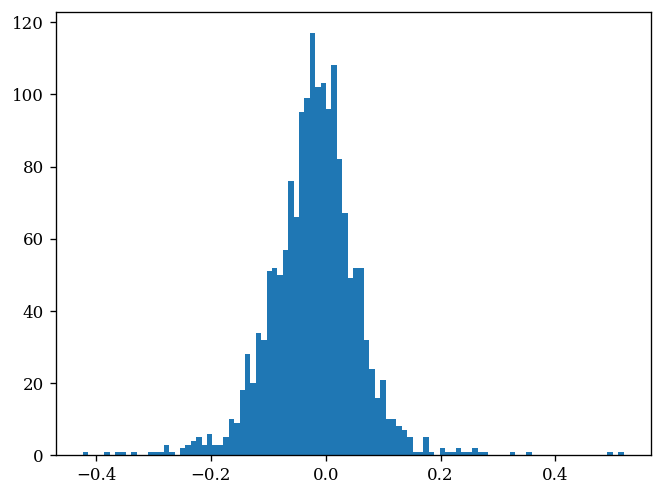

In [11]:
print(optx.RESULTS[sol.result])
print(min_fn(ode_model, args))
print(min_fn(trained_ode, args))
vals = np.concatenate([leaf.flatten() for leaf in jtu.leaves(trained_ode)])
plt.hist(vals, bins=100)
plt.show()

File 04481_001_06_03_1
Star HD-41094
Filter F430M
nints 905
ngroups 20

Original Model


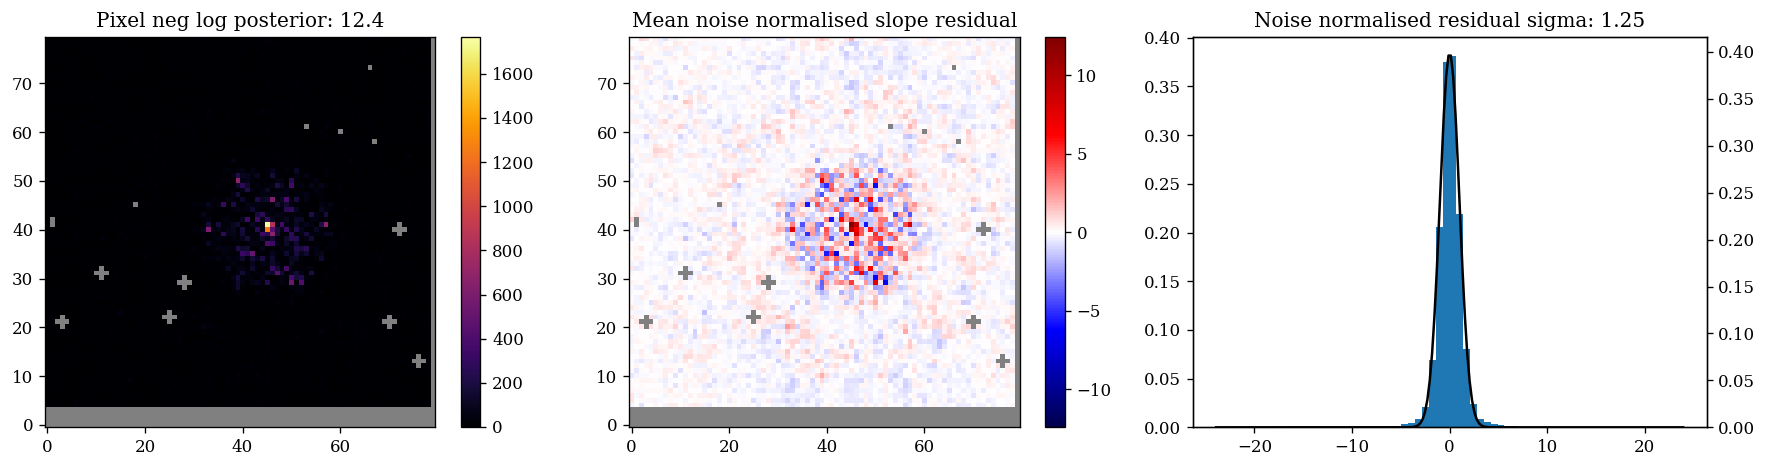

ODE Model


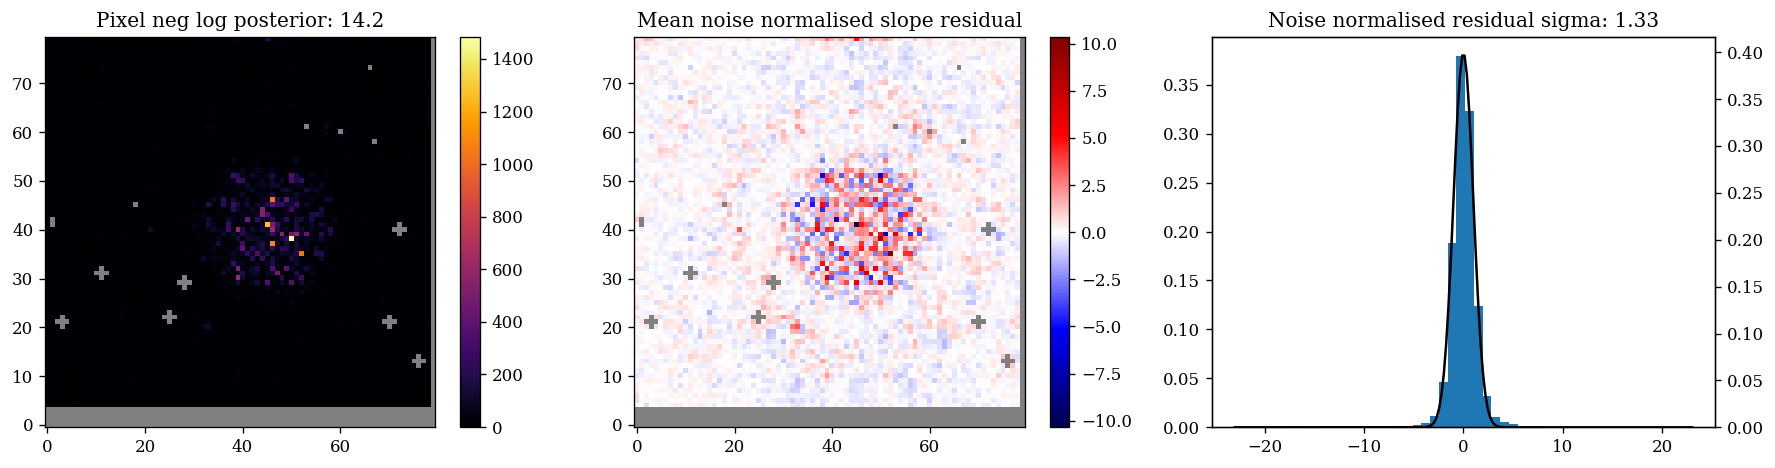

File 04481_001_02_03_2
Star HD-41094
Filter F480M
nints 760
ngroups 30

Original Model


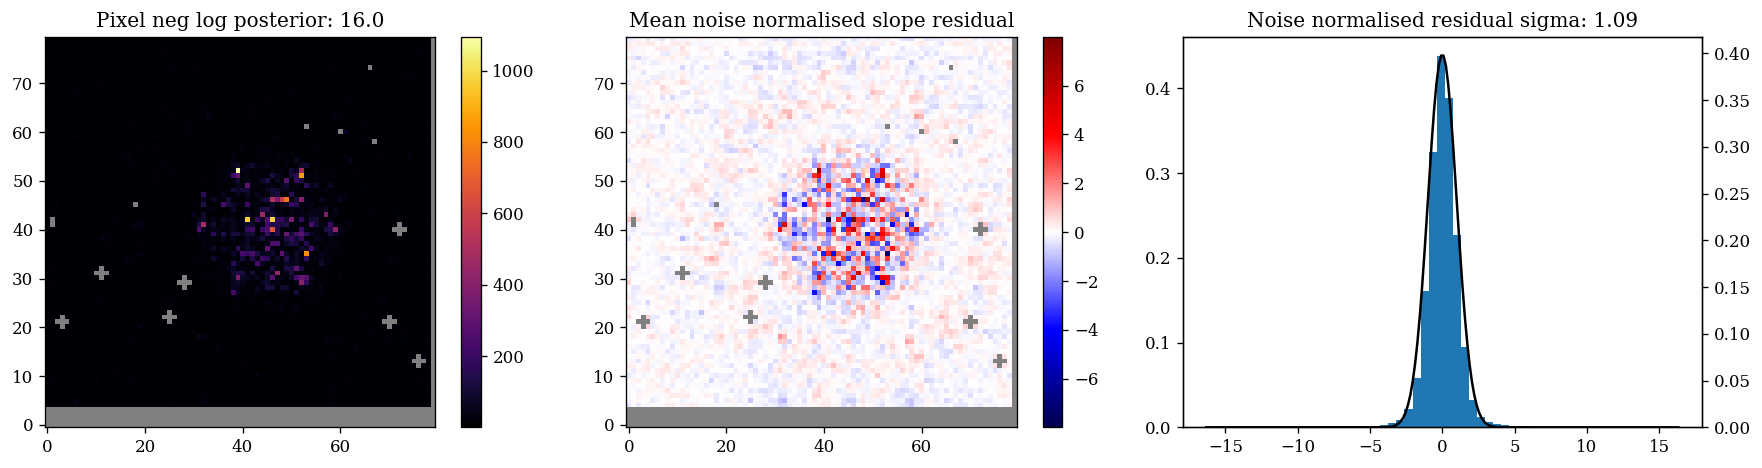

ODE Model


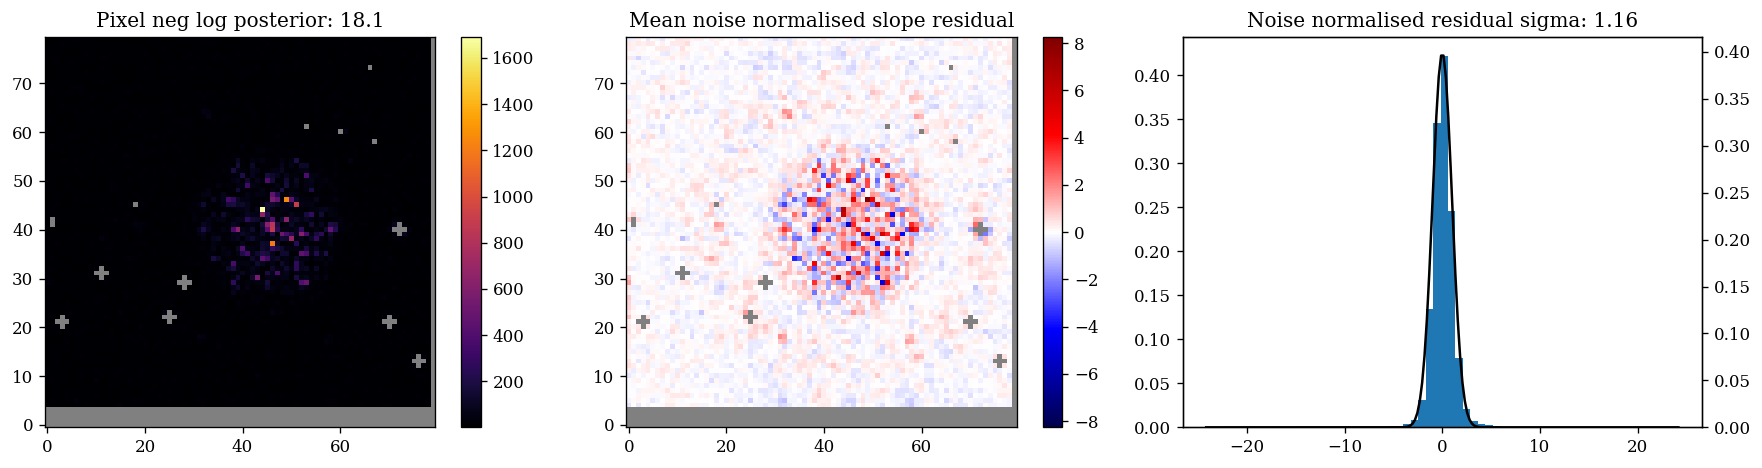

File 04481_001_04_03_1
Star HD-41094
Filter F380M
nints 1060
ngroups 11

Original Model


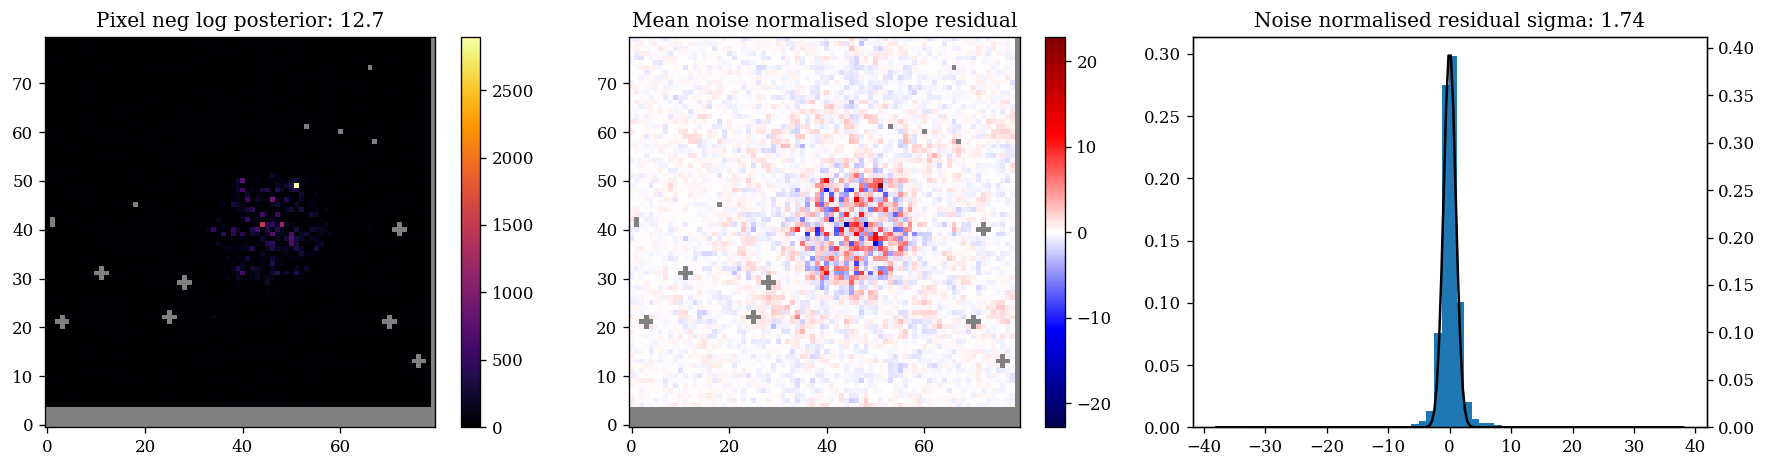

ODE Model


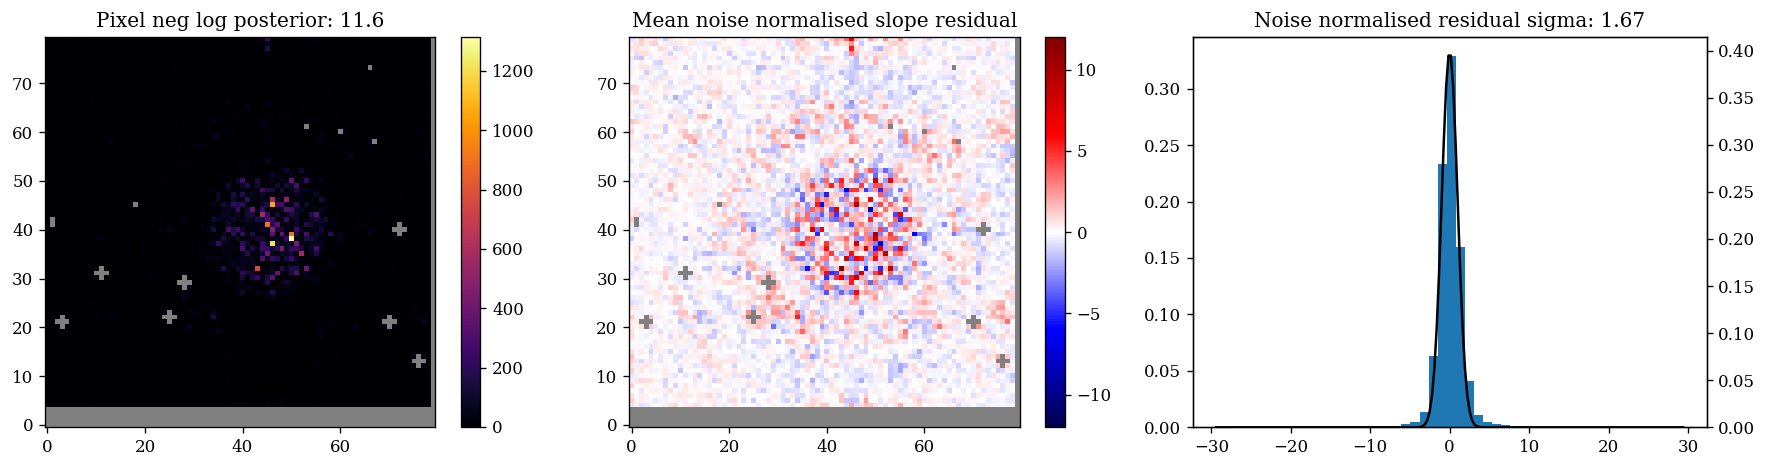

In [12]:
from amigo.plotting import summarise_fit

for exp in exposures[::2]:
    exp.print_summary()
    print("Original Model")
    summarise_fit(exp, model)
    print("ODE Model")
    summarise_fit(exp, model.set("ramp", trained_ode))

## Get new data to test on

In [22]:
new_files = load_cal("data/JWST", dithers=5)
model, new_exposures = initialise_model(new_files, PointFit(), Teff_cache="../data/Teffs")
ramp = MinimalConv(*build_pooled_layers(config["width"], config["depth"]))
model = populate_from_state(model.set("ramp", ramp), calib_state)

train_exposures, test_exposures = [], []
for exp in new_exposures:
    if int(exp.dither) in [1, 2]:
        train_exposures.append(exp)
    else:
        test_exposures.append(exp)

/Users/louis/mambaforge/envs/dx_test/lib/python3.12/site-packages/amigo/ramp_models.py:327: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Conv2d(


In [23]:
len(test_exposures)

9

File 04481_001_06_03_5
Star HD-41094
Filter F430M
nints 905
ngroups 20

Original Model


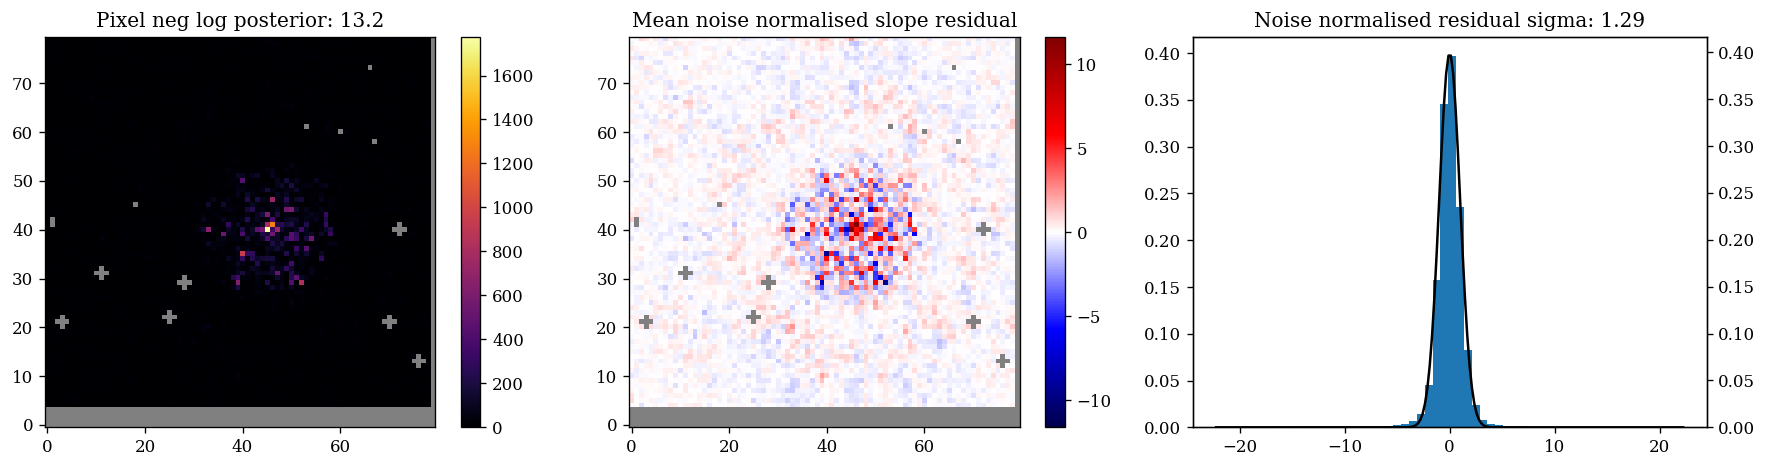

ODE Model (hasn't seen this data!)


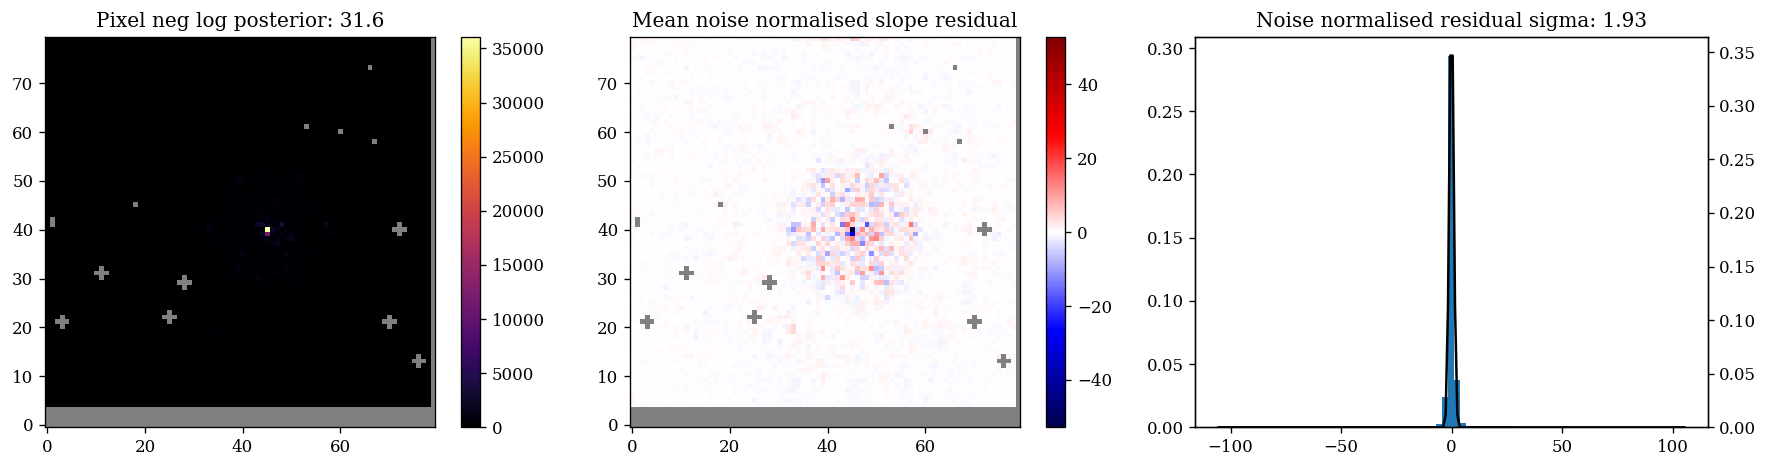

File 04481_001_06_03_4
Star HD-41094
Filter F430M
nints 905
ngroups 20

Original Model


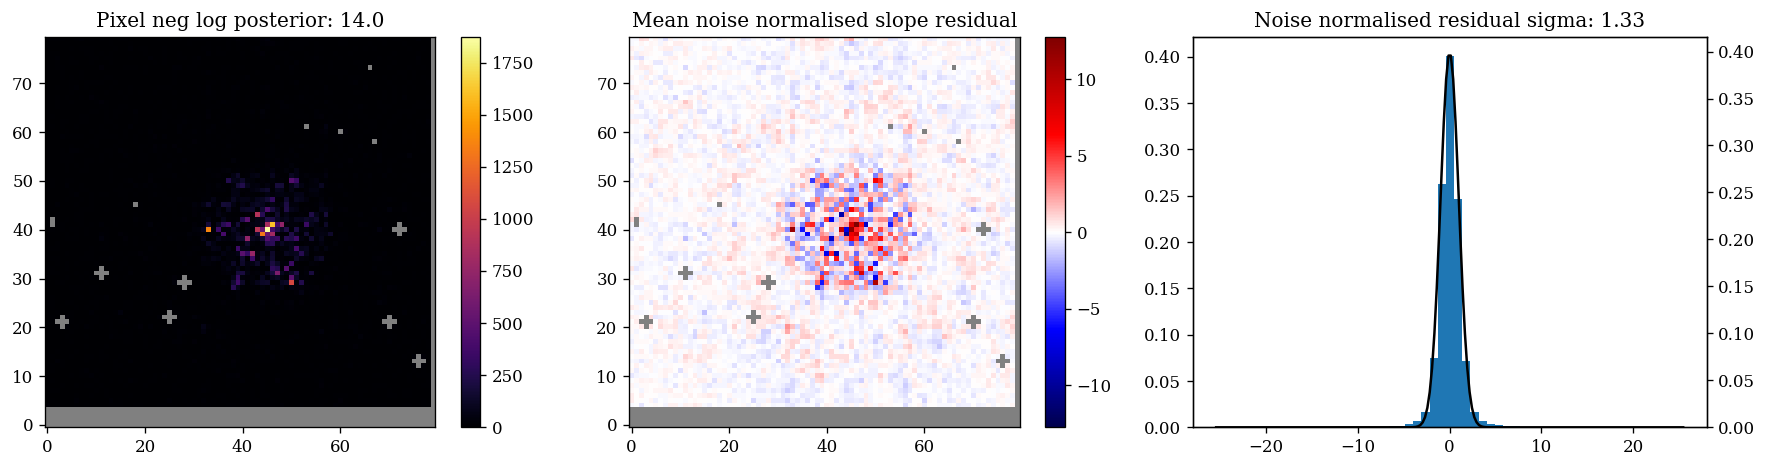

ODE Model (hasn't seen this data!)


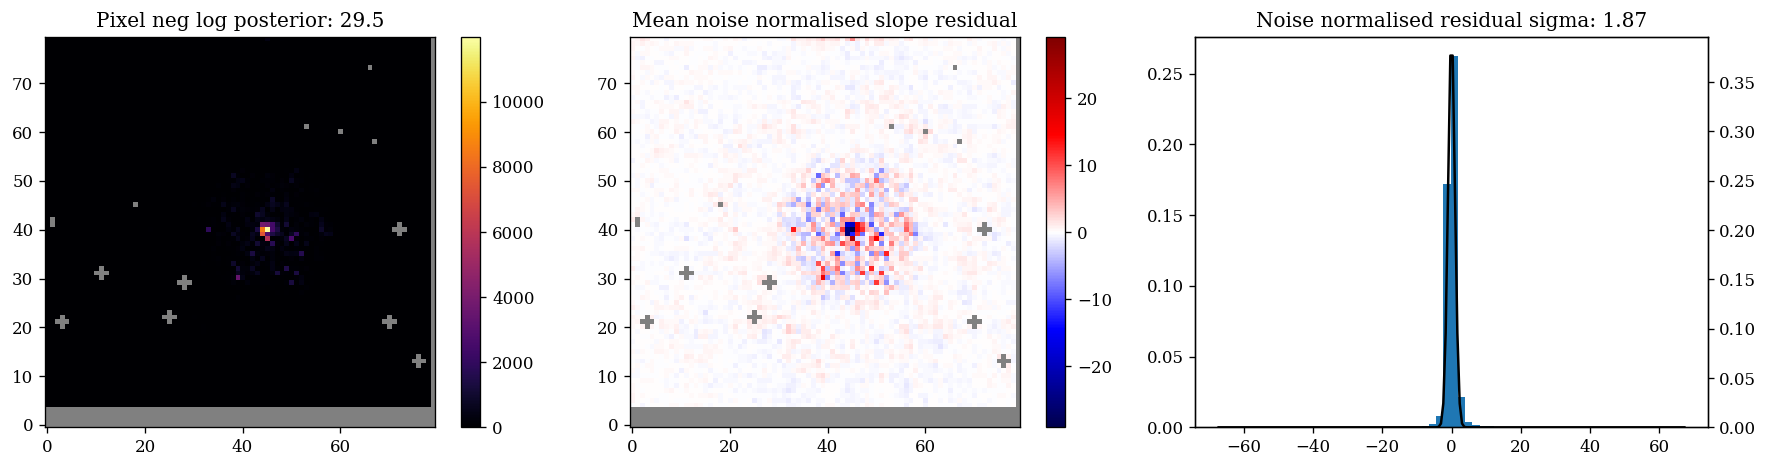

File 04481_001_06_03_3
Star HD-41094
Filter F430M
nints 905
ngroups 20

Original Model


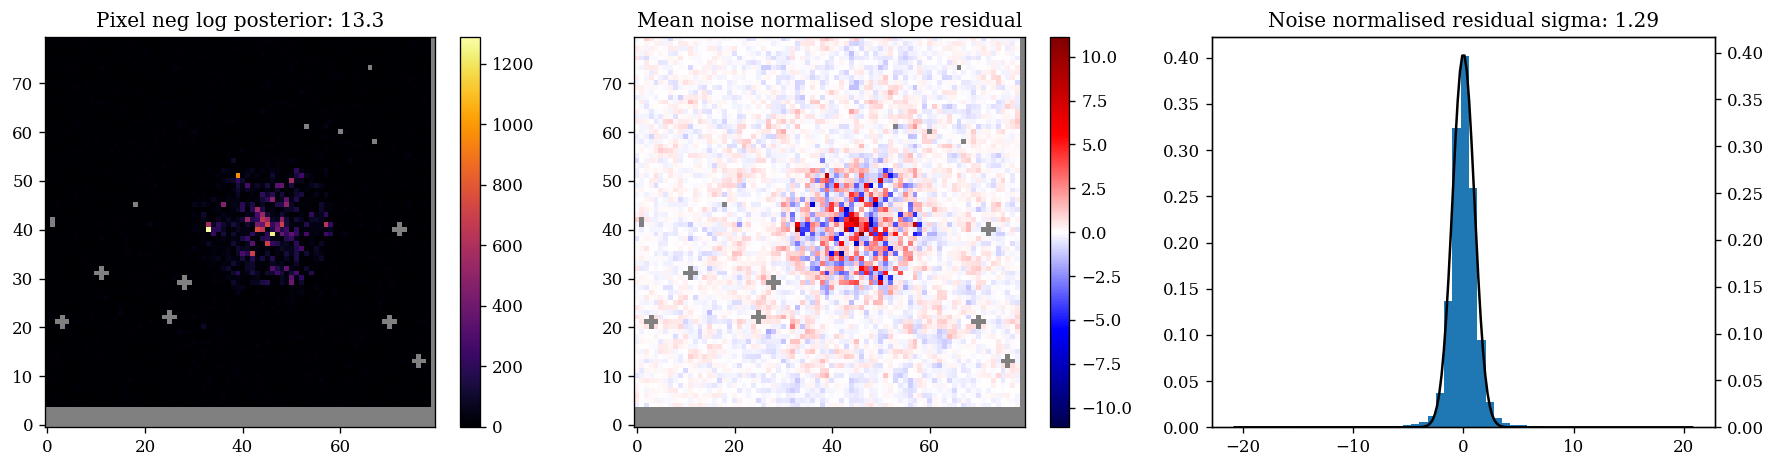

ODE Model (hasn't seen this data!)


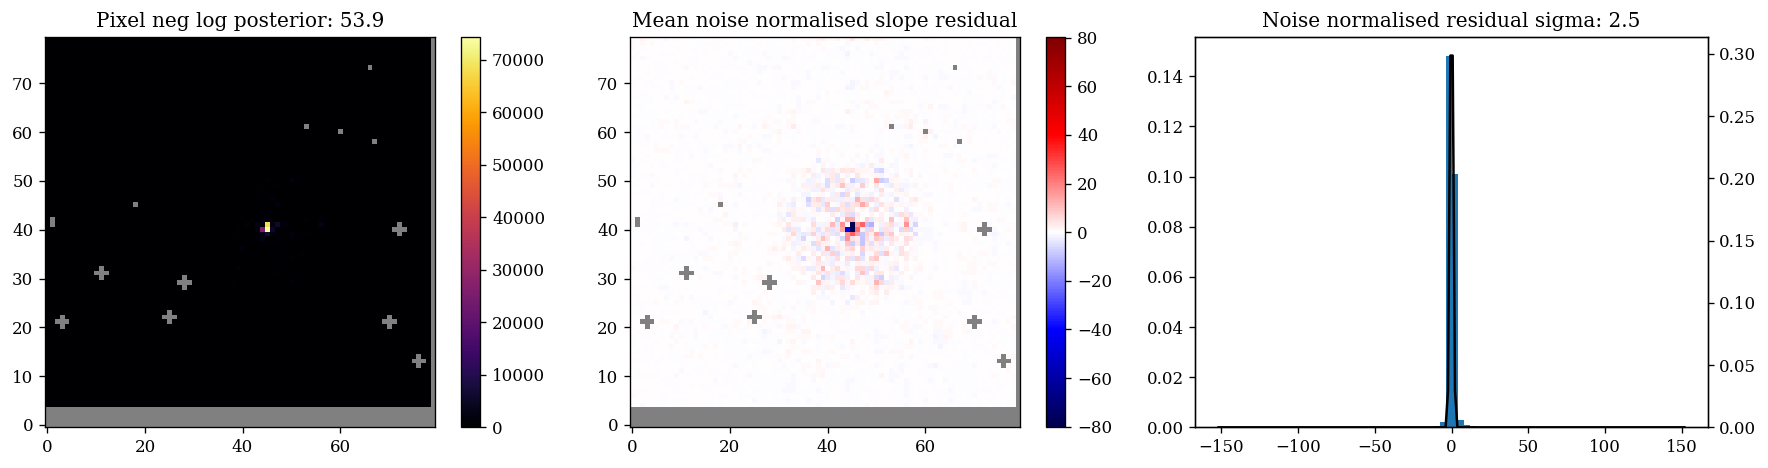

File 04481_001_04_03_3
Star HD-41094
Filter F380M
nints 1060
ngroups 11

Original Model


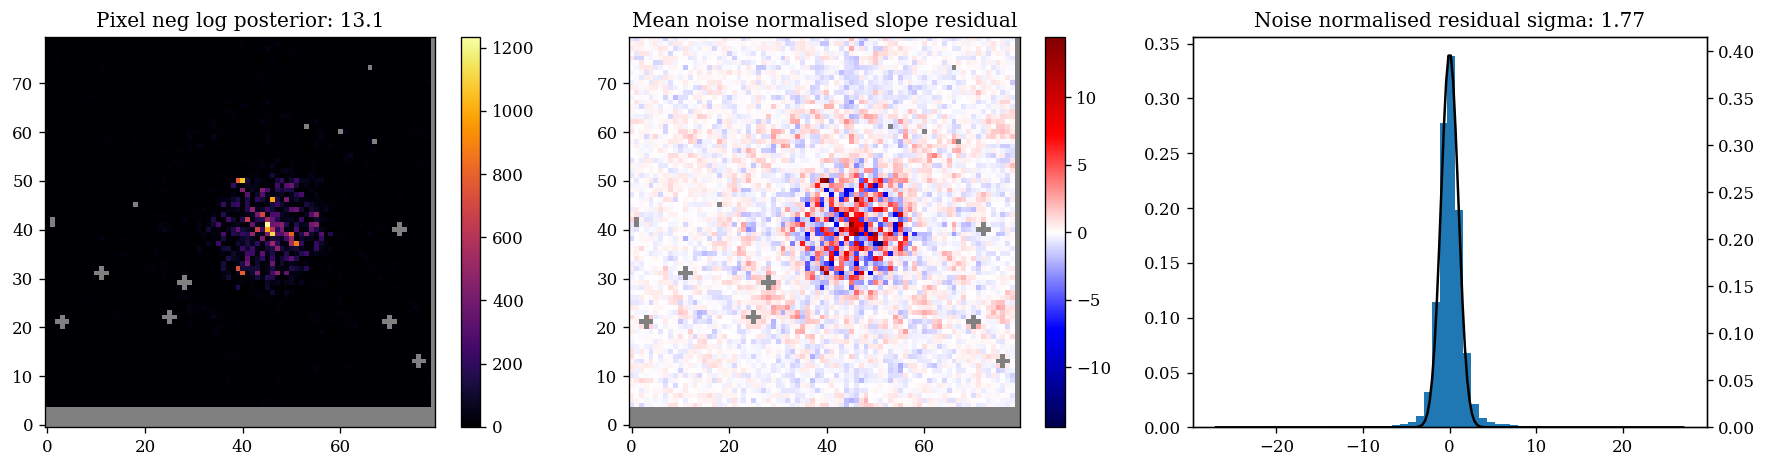

ODE Model (hasn't seen this data!)


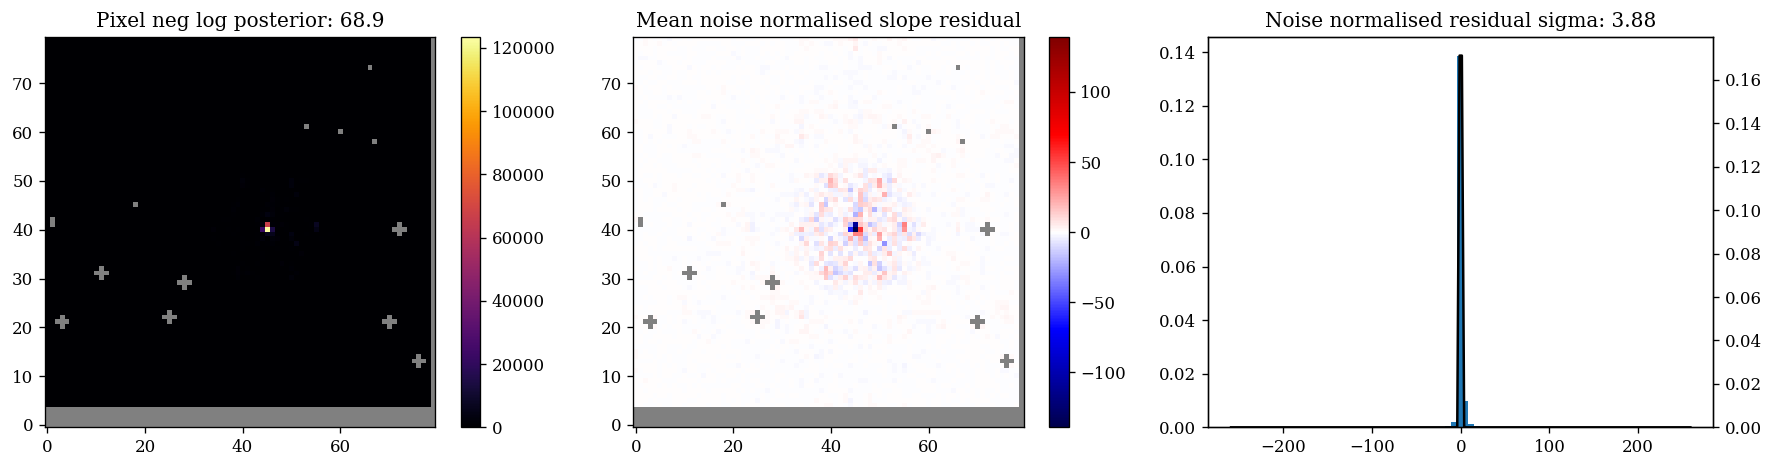

File 04481_001_02_03_5
Star HD-41094
Filter F480M
nints 760
ngroups 30

Original Model


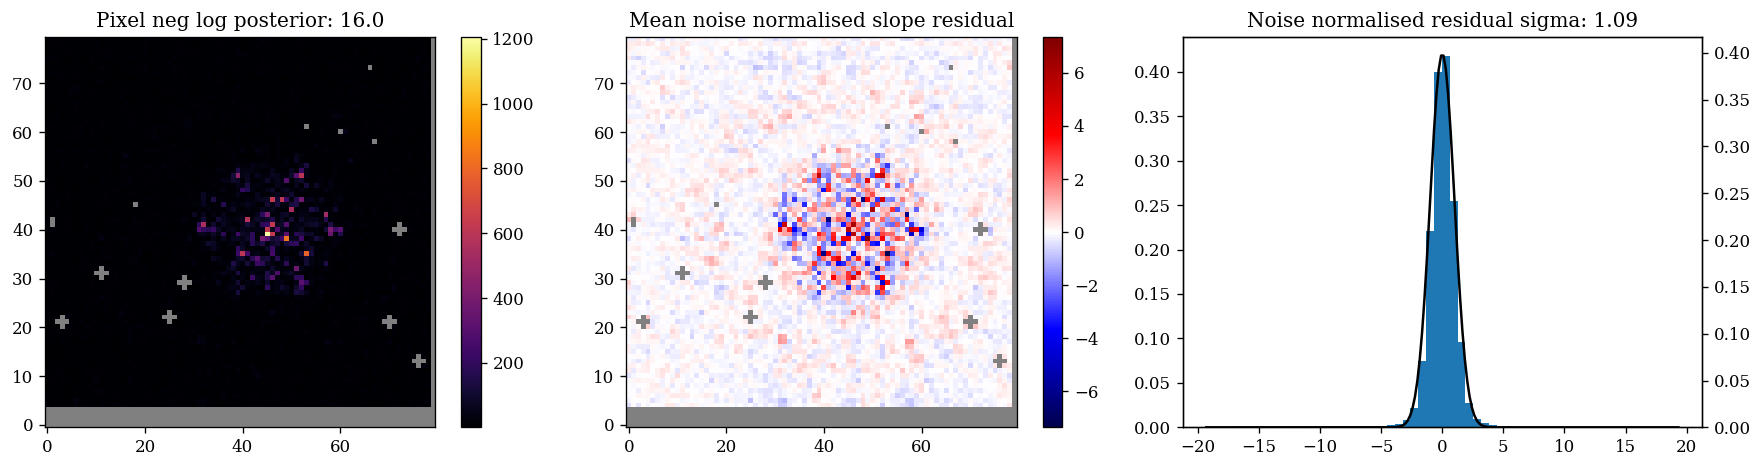

ODE Model (hasn't seen this data!)


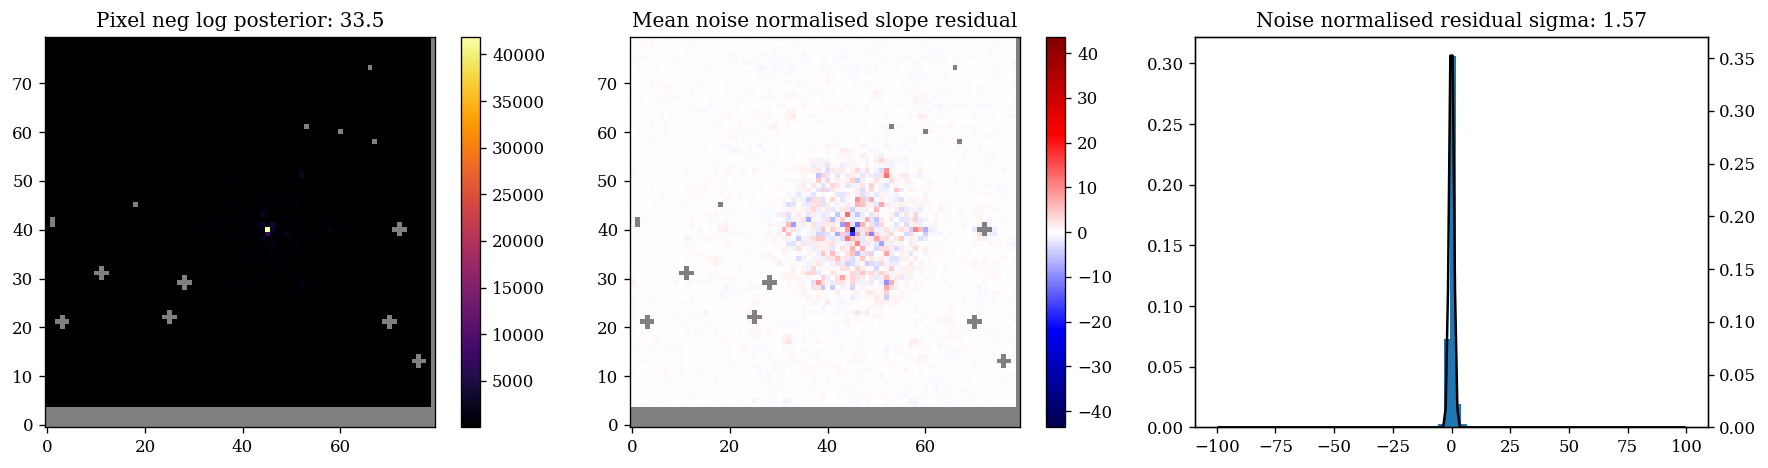

File 04481_001_04_03_4
Star HD-41094
Filter F380M
nints 1060
ngroups 11

Original Model


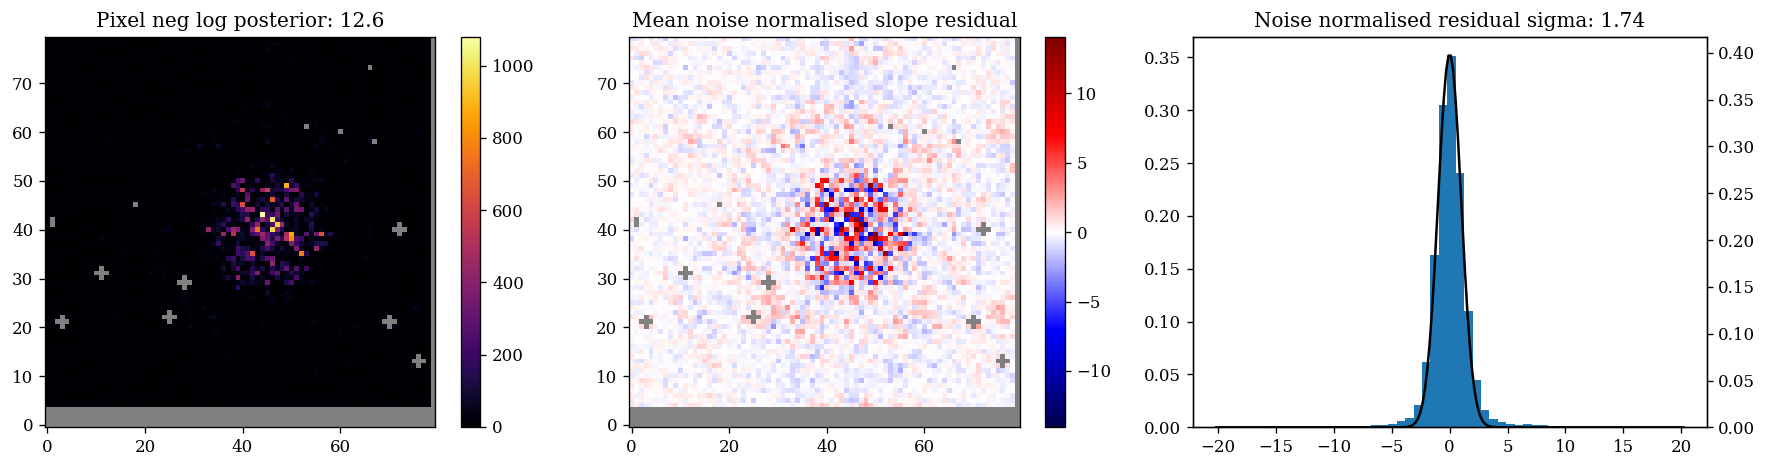

ODE Model (hasn't seen this data!)


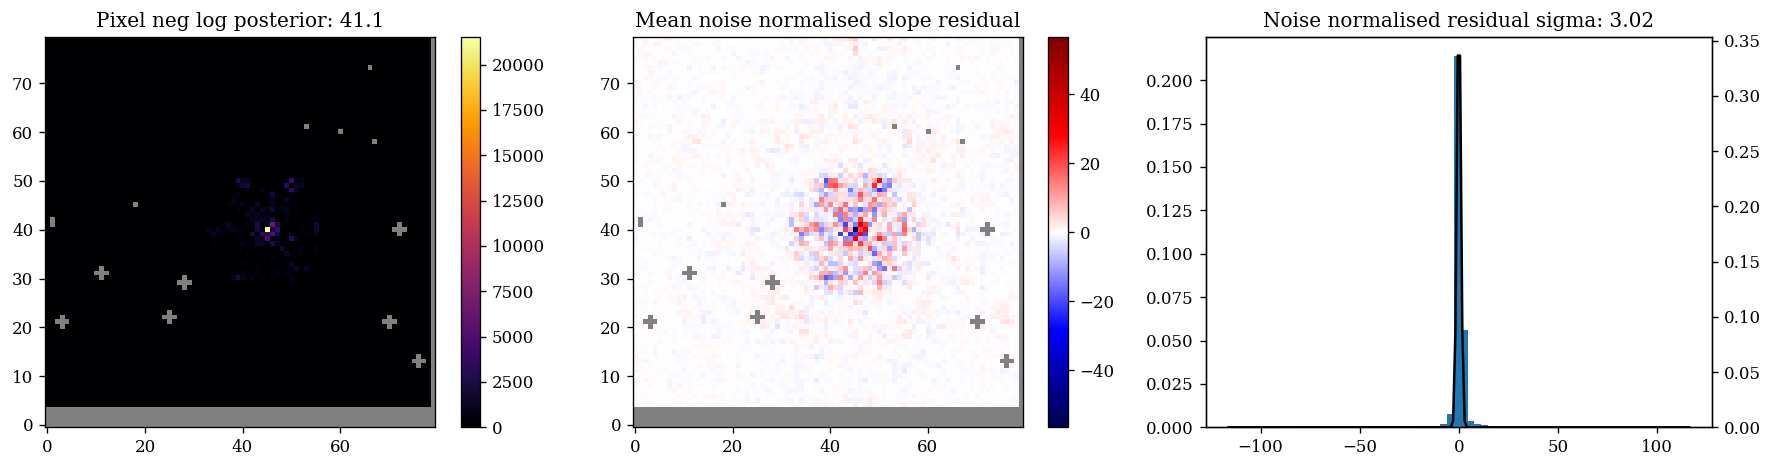

File 04481_001_02_03_3
Star HD-41094
Filter F480M
nints 760
ngroups 30

Original Model


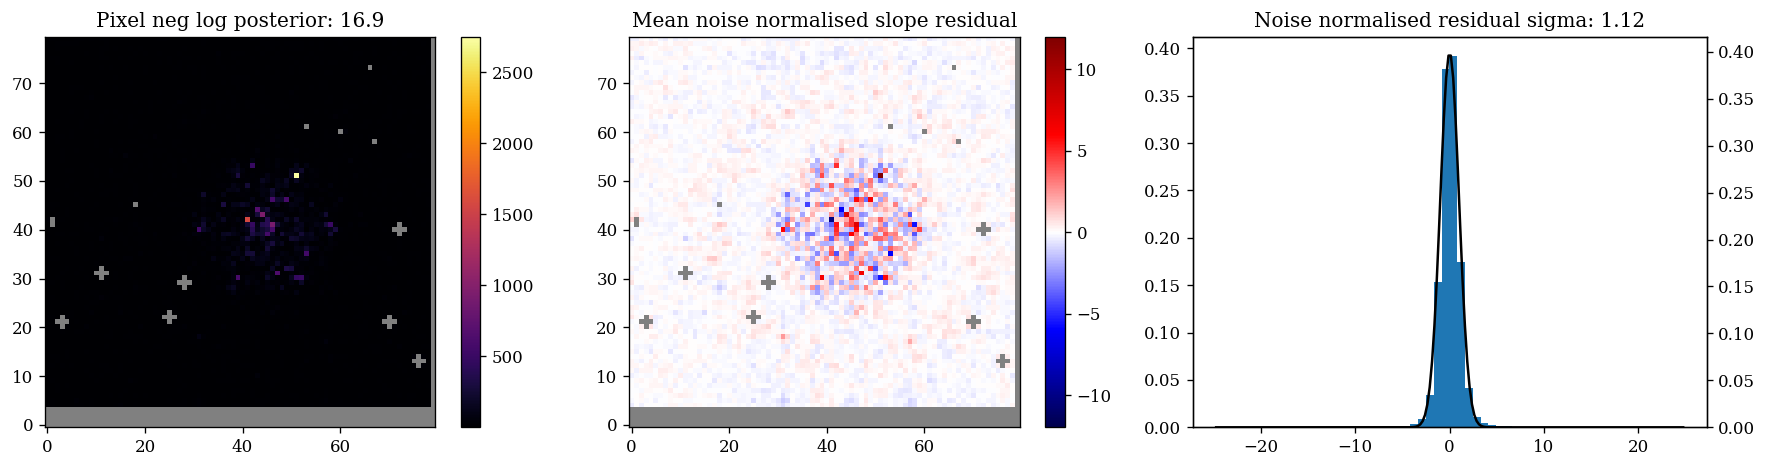

ODE Model (hasn't seen this data!)


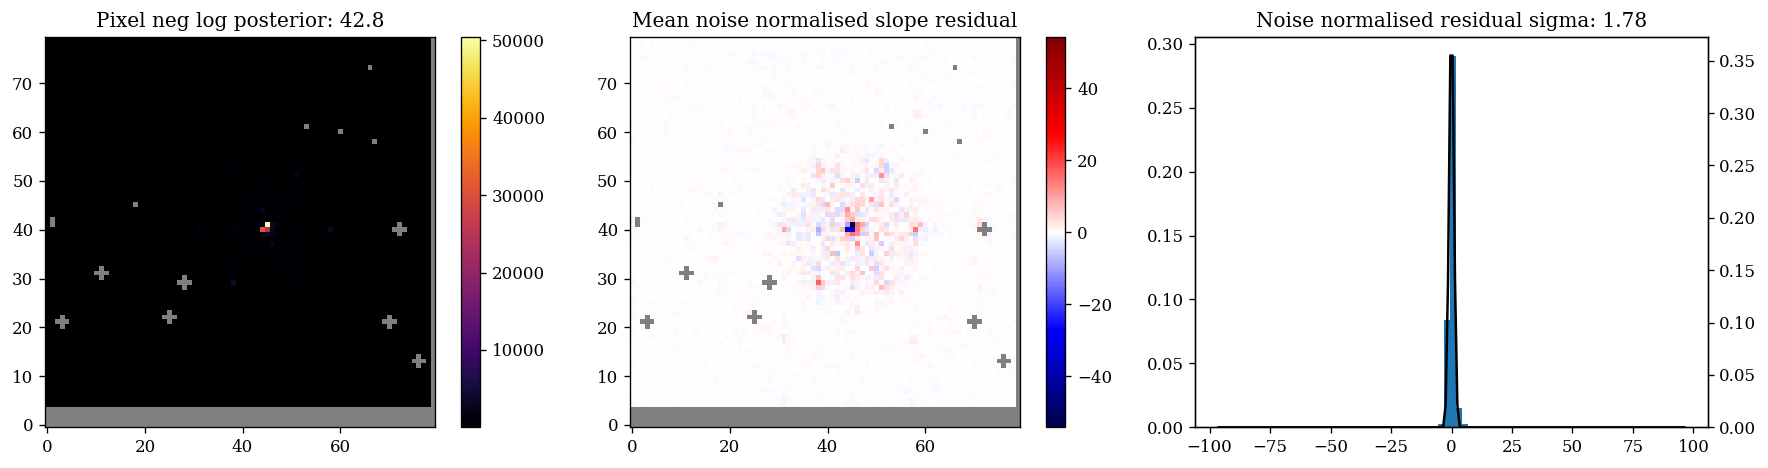

File 04481_001_04_03_5
Star HD-41094
Filter F380M
nints 1060
ngroups 11

Original Model


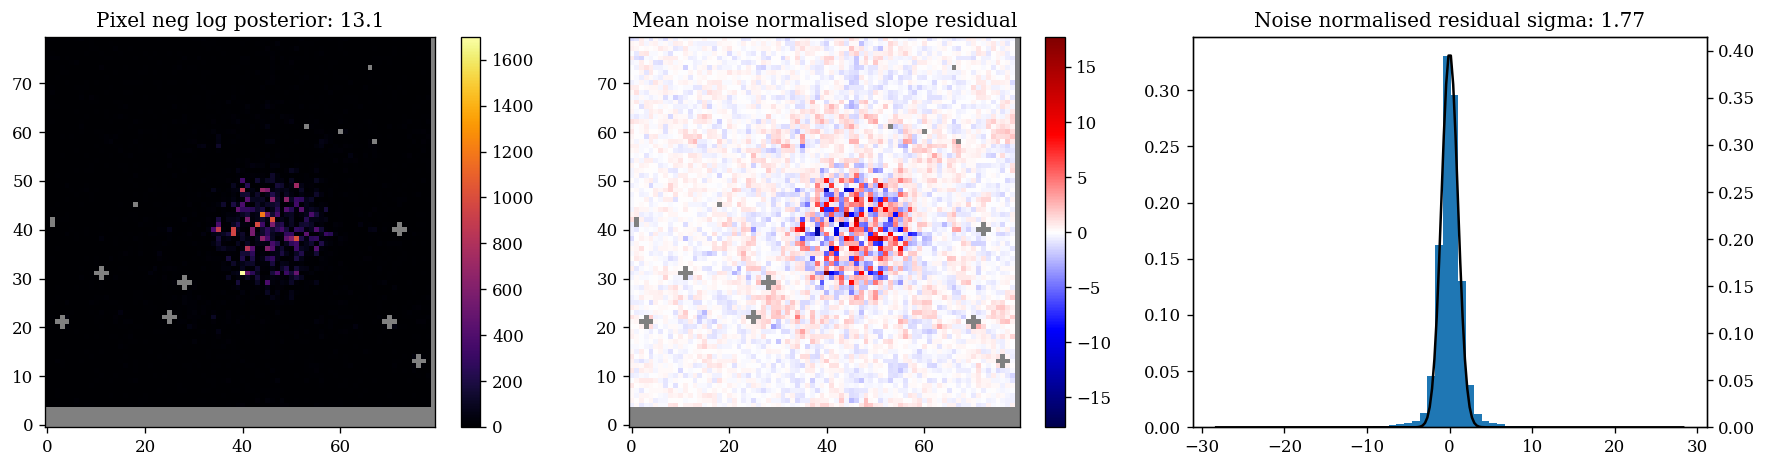

ODE Model (hasn't seen this data!)


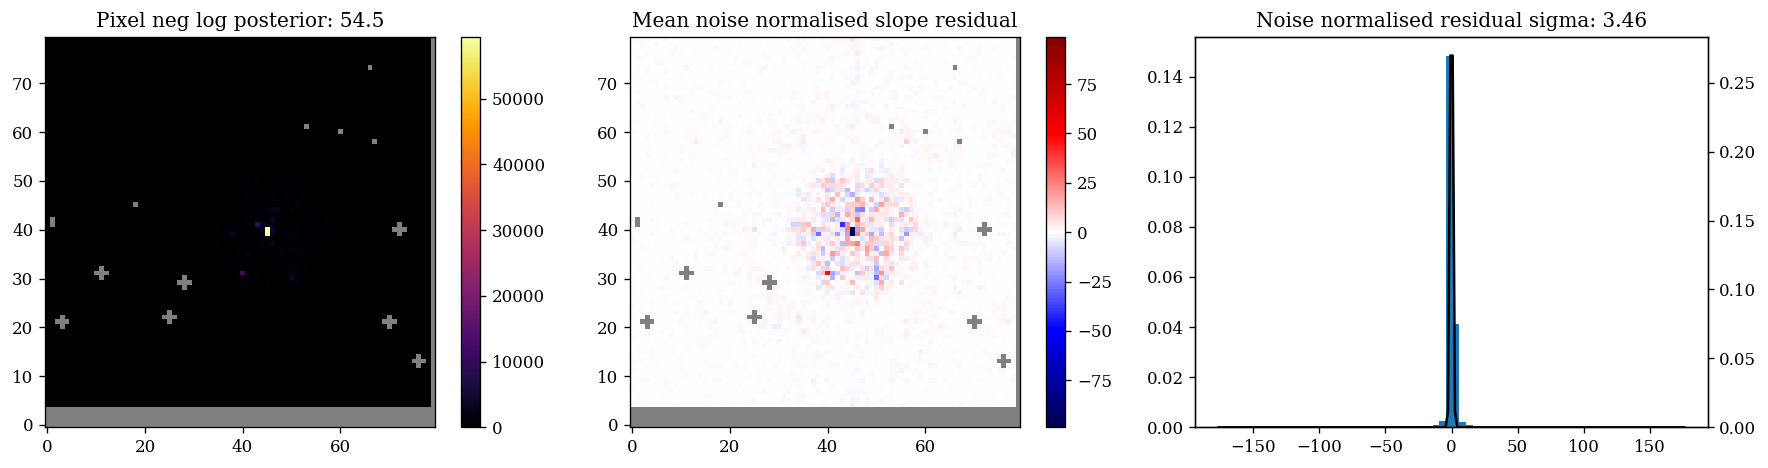

File 04481_001_02_03_4
Star HD-41094
Filter F480M
nints 760
ngroups 30

Original Model


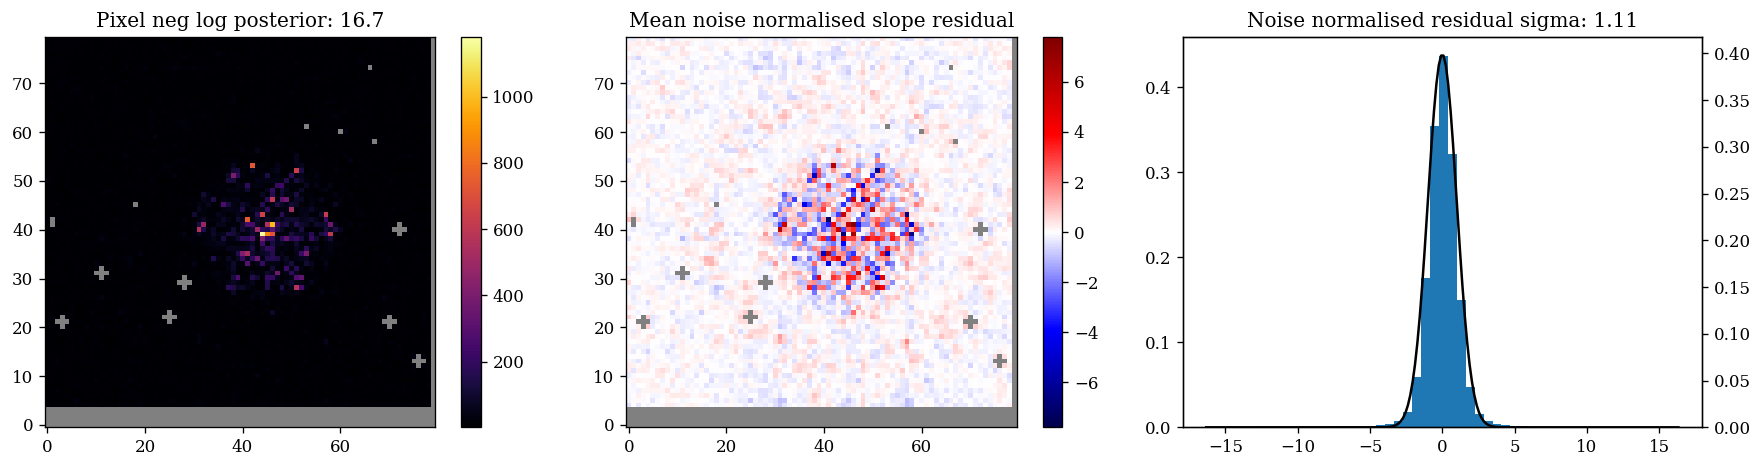

ODE Model (hasn't seen this data!)


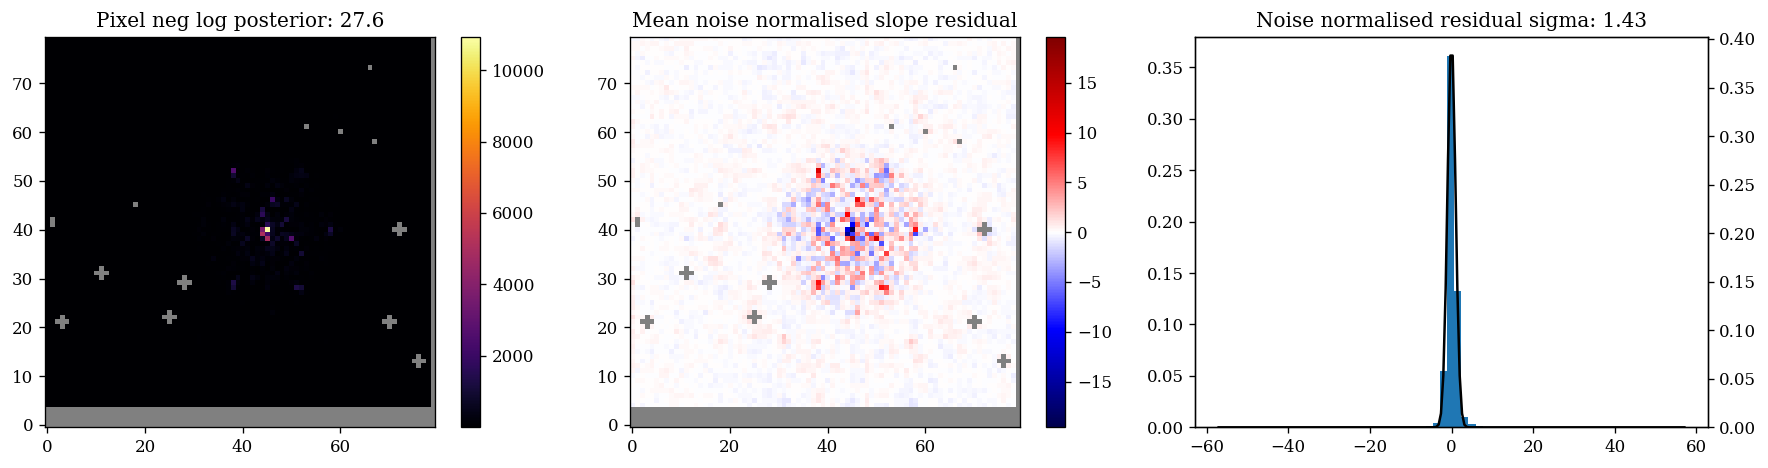

In [24]:
for exp in test_exposures:
    exp.print_summary()
    print("Original Model")
    summarise_fit(exp, model)
    print("ODE Model (hasn't seen this data!)")
    summarise_fit(exp, model.set("ramp", trained_ode))